# **Fine-tuning for Image Classification of Indian Food with 🤗 Transformers**

This notebook shows the steps to fine-tune a pretrained Vision model for Image Classification on an Indian Food dataset. The idea is to add a randomly initialized classification head on top of a pre-trained encoder, and fine-tune the model altogether on a labeled dataset.

### **Import Necessary Libraries**

In [1]:
!pip install -q datasets transformers
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.0 MB/s eta 0:00:00


In [2]:
!pip install -q evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.5 MB/s eta 0:00:00


In [3]:
from huggingface_hub import notebook_login
notebook_login()

Git-LFS to upload model checkpoints:

In [4]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!unzip "/content/drive/MyDrive/FoodClassification" -d /tmp/foodgrps

Streaming output truncated to the last 5000 lines.
  inflating: /tmp/foodgrps/chapati/253.jpg  
  inflating: /tmp/foodgrps/chapati/254.jpg  
  inflating: /tmp/foodgrps/chapati/255.jpg  
  inflating: /tmp/foodgrps/chapati/256.jpg  
  inflating: /tmp/foodgrps/chapati/257.jpg  
  inflating: /tmp/foodgrps/chapati/258.jpg  
  inflating: /tmp/foodgrps/chapati/259.jpg  
  inflating: /tmp/foodgrps/chapati/260.jpg  
  inflating: /tmp/foodgrps/chapati/261.jpg  
  inflating: /tmp/foodgrps/chapati/262.jpg  
  inflating: /tmp/foodgrps/chapati/263.jpg  
  inflating: /tmp/foodgrps/chapati/264.jpg  
  inflating: /tmp/foodgrps/chapati/265.jpg  
  inflating: /tmp/foodgrps/chapati/266.jpg  
  inflating: /tmp/foodgrps/chapati/267.jpg  
  inflating: /tmp/foodgrps/chapati/268.jpg  
  inflating: /tmp/foodgrps/chapati/269.jpg  
  inflating: /tmp/foodgrps/chapati/270.jpg  
  inflating: /tmp/foodgrps/chapati/271.jpg  
  inflating: /tmp/foodgrps/chapati/272.jpg  
  inflating: /tmp/foodgrps/chapati/273.jpg  
  in

In [9]:
from datasets import load_dataset
ds = load_dataset("imagefolder", data_dir="/tmp/foodgrps")
ds = ds['train']

Resolving data files:   0%|          | 0/6271 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [10]:
data = ds.train_test_split(test_size=0.15)
data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5328
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 941
    })
})

Save dataset to hugging face hub

In [ ]:
#data.push_to_hub("D0te/indian_food_images")

In [12]:
data = load_dataset("D0te/indian_food_images")

README.md:   0%|          | 0.00/953 [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/467M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/501M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/402M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/232M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5328 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/941 [00:00<?, ? examples/s]

In [13]:
pic = data['test'][53]
pic

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x900>,
 'label': 5}

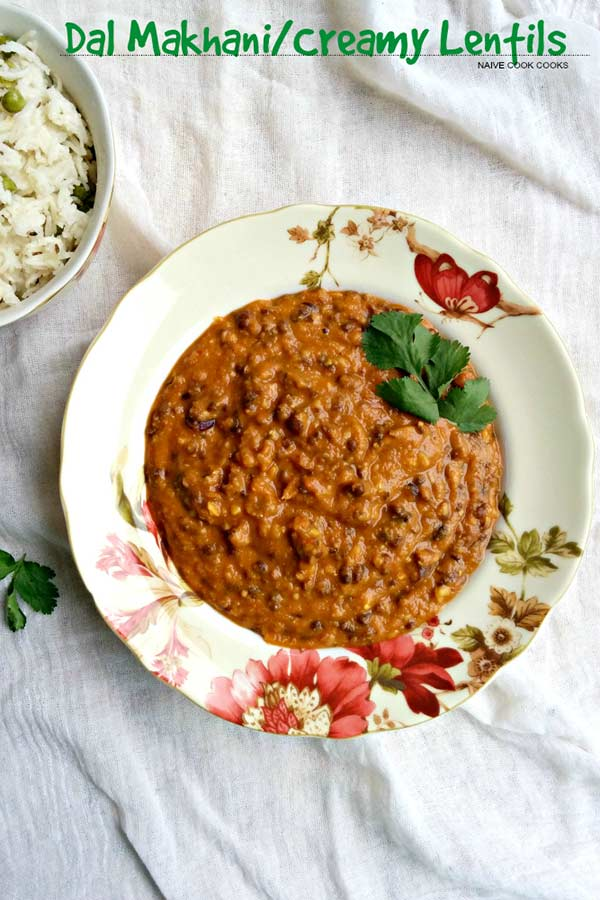

In [14]:
img = pic['image']
img

In [15]:
labels = data['train'].features['label']
labels

ClassLabel(names=['burger', 'butter_naan', 'chai', 'chapati', 'chole_bhature', 'dal_makhani', 'dhokla', 'fried_rice', 'idli', 'jalebi', 'kaathi_rolls', 'kadai_paneer', 'kulfi', 'masala_dosa', 'momos', 'paani_puri', 'pakode', 'pav_bhaji', 'pizza', 'samosa'], id=None)

In [16]:
labels.int2str(pic['label'])

'dal_makhani'

### **Model Fine-tuning**

In [17]:
import evaluate

metric = evaluate.load("accuracy")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [18]:
labels = data["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

Data Preprocessing

In [19]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [20]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

In [21]:
normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [
            RandomResizedCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

In [22]:
image_size = feature_extractor.size["height"]

val_transforms = Compose(
        [
            Resize((image_size, image_size)),
            CenterCrop((image_size, image_size)),
            ToTensor(),
            normalize,
        ]
    )

In [23]:
def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["image"] = [image.convert("RGB") for image in example_batch["image"]]
    example_batch["pixel_values"] = [train_transforms(image) for image in example_batch["image"]]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["image"] = [image.convert("RGB") for image in example_batch["image"]]
    example_batch["pixel_values"] = [val_transforms(image) for image in example_batch["image"]]
    return example_batch

In [24]:
# split up training into training + validation
train_ds = data['train']
val_ds = data['test']

In [25]:
train_ds.features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['burger', 'butter_naan', 'chai', 'chapati', 'chole_bhature', 'dal_makhani', 'dhokla', 'fried_rice', 'idli', 'jalebi', 'kaathi_rolls', 'kadai_paneer', 'kulfi', 'masala_dosa', 'momos', 'paani_puri', 'pakode', 'pav_bhaji', 'pizza', 'samosa'], id=None)}

In [26]:
train_ds.reset_format()

In [27]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [29]:
train_ds.set_format("torch")
train_ds[0]

{'image': tensor([[[216, 217, 219,  ..., 240, 240, 240],
          [219, 220, 222,  ..., 240, 240, 240],
          [224, 225, 228,  ..., 238, 238, 238],
          ...,
          [192, 195, 199,  ..., 156, 156, 156],
          [198, 202, 204,  ..., 156, 156, 156],
          [198, 202, 204,  ..., 156, 156, 156]],
 
         [[220, 221, 223,  ..., 243, 243, 243],
          [223, 224, 226,  ..., 243, 243, 243],
          [228, 229, 232,  ..., 241, 241, 241],
          ...,
          [196, 199, 203,  ..., 160, 160, 160],
          [202, 206, 208,  ..., 160, 160, 160],
          [202, 206, 208,  ..., 160, 160, 160]],
 
         [[223, 224, 226,  ..., 248, 248, 248],
          [226, 227, 229,  ..., 248, 248, 248],
          [231, 232, 235,  ..., 246, 246, 246],
          ...,
          [195, 198, 202,  ..., 159, 159, 159],
          [201, 205, 207,  ..., 159, 159, 159],
          [201, 205, 207,  ..., 159, 159, 159]]], dtype=torch.uint8),
 'label': tensor(5)}

In [30]:
from transformers import ViTForImageClassification
model_name_or_path = 'google/vit-base-patch16-224-in21k'
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    'finetuned-indian-food',
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=True,
  report_to='tensorboard',
  load_best_model_at_end=True,
  hub_strategy="end"
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [33]:
import numpy as np

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [34]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [35]:
from transformers import Trainer
trainer = Trainer(
    model,
    training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

<ipython-input-35-2d1bc5ab2524>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [37]:
from torchvision import transforms

def preprocess_train(examples):
    # Define image transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize (adjust based on model requirements)
    ])

    # Apply transform
    examples["pixel_values"] = [transform(image) for image in examples["image"]]
    return examples

train_ds.set_transform(preprocess_train)

In [38]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  eval_accuracy               =     0.0659
  eval_loss                   =     2.9893
  eval_model_preparation_time =     0.0123
  eval_runtime                = 0:07:24.19
  eval_samples_per_second     =      2.118
  eval_steps_per_second       =      0.266


In [39]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": 'indian_food_images',
    "tags": ['image-classification'],
}

if training_args.push_to_hub:
    trainer.push_to_hub('🍻 cheers', **kwargs)
else:
    trainer.create_model_card(**kwargs)

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

events.out.tfevents.1741030664.abc4688f57cf.168.0:   0%|          | 0.00/409 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

In [40]:
from transformers import AutoModelForImageClassification, AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("D0te/finetuned-indian-food")
model = AutoModelForImageClassification.from_pretrained("D0te/finetuned-indian-food")

preprocessor_config.json:   0%|          | 0.00/353 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.51k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

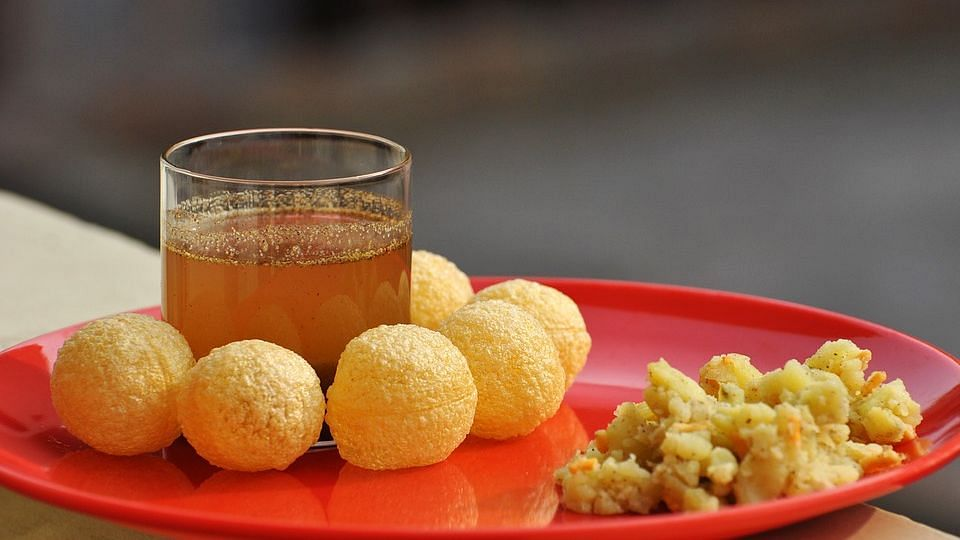

In [46]:
from PIL import Image
import requests

url = 'https://huggingface.co/D0te/finetuned-indian-food/resolve/main/126.jpg'
image = Image.open(requests.get(url, stream=True).raw)
image

In [ ]:
from transformers import AutoModelForImageClassification, AutoFeatureExtractor

repo_name = "D0te/finetuned-indian-food"

feature_extractor = AutoFeatureExtractor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

In [ ]:
# prepare image for the model
encoding = feature_extractor(image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

In [ ]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(**encoding)
  logits = outputs.logits

In [ ]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

## **Pipeline API**

In [ ]:
from transformers import pipeline
pipe = pipeline("image-classification", "D0te/finetuned-indian-food")

In [ ]:
url = 'https://huggingface.co/D0te/finetuned-indian-food/resolve/main/126.jpg'
image = Image.open(requests.get(url, stream=True).raw)

pipe(image)

In [ ]:
pipe = pipeline("image-classification",
                model=model,
                feature_extractor=feature_extractor)

In [ ]:
pipe(image)